# Netflix Stock Price Prediction ML Project

#### Mohamed Youssef - 211001821


## Index

* [Including Necessary Libraries](#libs)
<br>
* [Data Preprocessing & Cleaning](#dataset)
<br>
* [Data Visualization](#vis)
<br>
* [Random Forest Model](#m1)
<br>
* [Polynomial Regression Model](#m2)
<br>
* [Ada Boost Model](#m3)
<br>
* [Model Comparison](#compare)


## Including Necessary Libraries <a id='libs'></a>


In [22]:
# Python built-in libraries
import datetime as dt
import time
import warnings

# Libraries for preprocessing and visualizing the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ML models evaluation metrics
from sklearn import metrics

# Sklearn ML models classes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor

In [23]:
# Disabling warnings
def warn(*args, **kwargs):
    pass


warnings.warn = warn

## Data Preprocessing & Cleaning <a id='dataset'></a>


### Data Gathering

In [24]:
# Importing the dataset csv file
NFLX_df = pd.read_csv("./NFLX.csv")

NFLX_df.sample(10)  # Showing 10 random records

,Date,Open,High,Low,Close,Adj Close,Volume
890,2021-07-16,541.809998,544.059998,527.049988,530.309998,530.309998,3442100
155,2018-08-14,342.089996,342.410004,336.250000,337.489990,337.489990,5805200
433,2019-09-23,268.350006,273.390015,261.890015,265.920013,265.920013,13478600
148,2018-08-03,347.750000,347.859985,338.480011,343.089996,343.089996,8848400
512,2020-01-15,338.679993,343.170013,336.600006,339.070007,339.070007,5158000
14,2018-01-23,255.050003,257.709991,248.020004,250.289993,250.289993,27705300
99,2018-05-24,344.339996,354.000000,341.119995,349.290009,349.290009,14758600
1126,2022-06-23,180.500000,182.759995,175.869995,181.710007,181.710007,9538200
375,2019-07-01,373.500000,376.660004,372.000000,374.600006,374.600006,4992600
164,2018-08-27,367.149994,374.489990,360.000000,364.579987,364.579987,17427300


### Statistical Analysis

In [25]:
# Generating descriptive statistics
NFLX_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,387.752923,393.907275,381.288920,387.752430,387.752430,8.204729e+06
std,119.680365,120.384675,118.574058,119.378060,119.378060,6.860656e+06
min,163.960007,172.059998,162.710007,166.369995,166.369995,1.144000e+06
25%,298.714996,303.549988,292.399994,298.550003,298.550003,4.400600e+06
50%,361.959991,367.329987,356.619995,361.809998,361.809998,6.525600e+06
75%,495.000000,502.895004,487.770005,494.455002,494.455002,9.915100e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,1.333875e+08


In [26]:
# Checking for missing values
NFLX_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


### Data Cleaning

In [27]:
# Setting the data feature as the index
NFLX_df.set_index("Date", inplace=True, drop=False)

In [28]:
# Converting the Date column to datetime format and then to Unix timestamp
NFLX_df["Date"] = pd.to_datetime(NFLX_df["Date"])
NFLX_df["Date"] = (NFLX_df["Date"] - pd.Timestamp("1970-01-01")) / pd.Timedelta(days=1)

In [29]:
print(
    "Number of records where the 'Close' column values is equal to the 'Adj Close' column values",
    NFLX_df[NFLX_df["Close"] == NFLX_df["Adj Close"]].shape[0],
)
print("Number of total records", NFLX_df.shape[0])

Number of records where the 'Close' column values is equal to the 'Adj Close' column values 1259
Number of total records 1259


In [30]:
# Since the 'Close' column values is always equal to the 'Adj Close' column values we will drop the 'Adj Close' column
NFLX_df.__delitem__("Adj Close")

In [31]:
# Also the 'Volume' column won't be needed since it doesn't describe the NFLX stock it describes the market
NFLX_df.__delitem__("Volume")

In [32]:
print(
    "Number of columns after dropping the 'Adj Close' and 'Volume' columns",
    NFLX_df.shape[1],
)

Number of columns after dropping the 'Adj Close' and 'Volume' columns 5


In [33]:
# Checking the data types of the columns
NFLX_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 2018-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1259 non-null   float64
 1   Open    1259 non-null   float64
 2   High    1259 non-null   float64
 3   Low     1259 non-null   float64
 4   Close   1259 non-null   float64
dtypes: float64(5)
memory usage: 91.3+ KB


In [34]:
# Generating descriptive statistics
NFLX_df.describe()

,Date,Open,High,Low,Close
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,18445.139793,387.752923,393.907275,381.288920,387.752430
std,527.238321,119.680365,120.384675,118.574058,119.378060
min,17533.000000,163.960007,172.059998,162.710007,166.369995
25%,17989.500000,298.714996,303.549988,292.399994,298.550003
50%,18445.000000,361.959991,367.329987,356.619995,361.809998
75%,18900.500000,495.000000,502.895004,487.770005,494.455002
max,19356.000000,692.349976,700.989990,686.090027,691.690002


In [35]:
# Showing 5 random records
NFLX_df.sample(5)

,Date,Open,High,Low,Close
Date,,,,,
2022-03-18,19069.0,372.000000,381.799988,368.470001,380.600006
2020-02-11,18303.0,373.750000,378.109985,369.720001,373.690002
2021-01-08,18635.0,511.309998,513.239990,504.510010,510.399994
2022-04-01,19083.0,376.799988,380.869995,368.500000,373.470001
2022-09-07,19242.0,220.210007,229.330002,218.270004,228.960007


In [36]:
# Splitting the data into features and target variable
X = NFLX_df[["Open", "High", "Low"]]
y = NFLX_df[["Close"]]

In [37]:
# Splitting the data into training and testing sets (80% training and 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=1
)

In [38]:
# Showing the shape of the training and testing sets
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

X_train shape (1007, 3)
X_test shape (252, 3)
y_train shape (1007, 1)
y_test shape (252, 1)


## Data Visualization <a id='vis'></a>

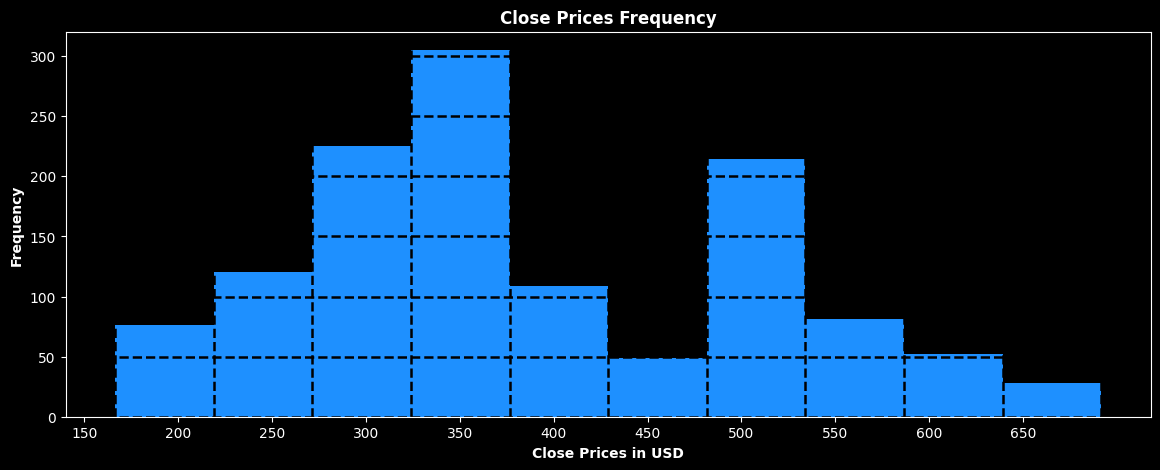

In [39]:
# Visualizing the datasets closing prices frequency
plt.figure(figsize=(14, 5))
plt.hist(NFLX_df["Close"], color="dodgerblue")
plt.xlabel("Close Prices in USD", weight="bold")
plt.ylabel("Frequency", weight="bold")
plt.title("Close Prices Frequency", weight="bold")
plt.xticks(np.arange(150, 700, 50))
plt.yticks(np.arange(0, 350, 50))
plt.grid(axis="y", linestyle="--", color="black", linewidth=1.8)

# Draw a line dividing each bar
for bin_edge in np.histogram(NFLX_df["Close"])[1]:
    plt.axvline(bin_edge, color="black", linestyle="--", linewidth=1.8)

plt.show()

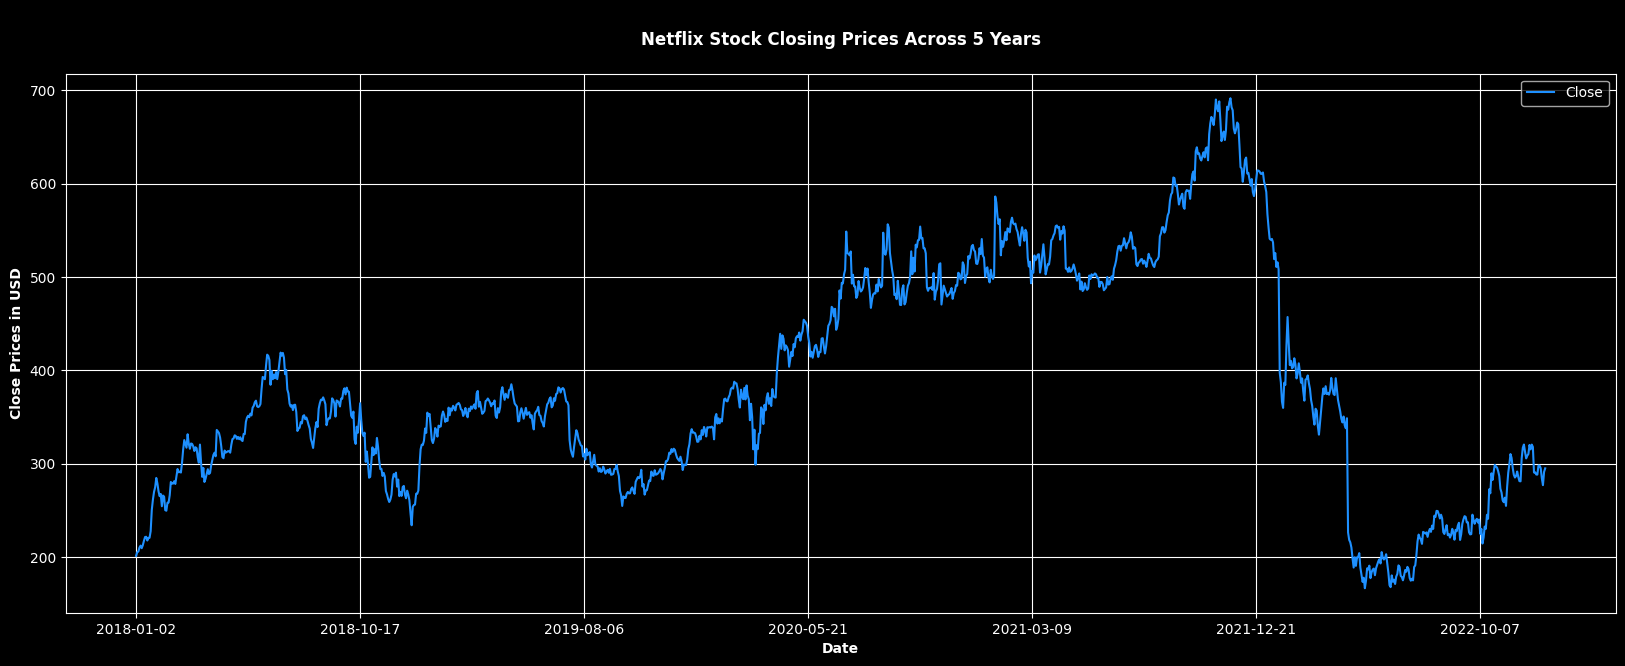

In [40]:
# Plotting the datasets closing prices against the index (Date)
NFLX_df["Close"].plot(color="dodgerblue", figsize=(20, 7))
plt.ylabel("Close Prices in USD", weight="bold")
plt.xlabel("Date", weight="bold")
plt.title("\nNetflix Stock Closing Prices Across 5 Years\n", weight="bold")
plt.grid()
plt.legend()
plt.show()

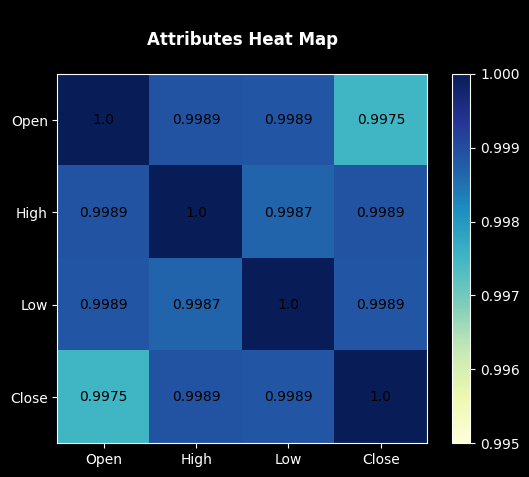

In [41]:
# Visualizing the correlation matrix through a heat map
corr = NFLX_df[["Open", "High", "Low", "Close"]].corr()
plt.imshow(corr, cmap="YlGnBu", interpolation="nearest", vmin=0.995)
plt.colorbar()

for i in range(4):
    for j in range(4):
        plt.annotate(
            str(round(corr.values[i][j], 4)),
            xy=(j, i),
            ha="center",
            va="center",
            color="black",
        )

plt.title("\nAttributes Heat Map\n", weight="bold")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

## Random Forest Regression<a id='m1'></a>

### Random Search Cross Validation

In [42]:
# Initializing the Random Forest Regressor
rf = RandomForestRegressor()

In [43]:
# Initializing the parameter grid
rf_parameter_grid = {
    "n_estimators": [20, 50, 100, 500, 1000],
    "max_depth": np.arange(1, 15, 1),
    "min_samples_split": np.arange(2, 10, 2),
    "min_samples_leaf": np.arange(1, 15, 2),
    "bootstrap": [True, False],
    "random_state": [1],
}

In [44]:
# Initializing the randomized search CV
rand_search_cross_valid = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_parameter_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=100,
    n_iter=200,
    return_train_score=True,
    random_state=1,
)

In [45]:
# Fitting the randomized search CV
rfr_start_time = time.time()
rand_search_cross_valid.fit(X_train, y_train.ravel())
rfr_elapsed_time = time.time() - rfr_start_time

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [46]:
# Obtaining the parameter values for every MSE, while also finding the best one
best_parameters = rand_search_cross_valid.best_params_
rscv_results = rand_search_cross_valid.cv_results_

# Printing the best parameters and the best MSE
for mean_score, parameters in zip(
    tuple(rscv_results["mean_test_score"]), tuple(rscv_results["params"])
):
    if parameters == best_parameters:
        print("Best MSE", "\t", "Best Parameters")
        print(round(-mean_score, 2), "\t\t", parameters)

# Printing the worst parameters and the worst MSE
for mean_score, parameters in zip(
    tuple(rscv_results["mean_test_score"]), tuple(rscv_results["params"])
):
    if parameters == rscv_results["params"][np.argmin(rscv_results["mean_test_score"])]:
        print("\nWorst MSE", "\t", "Worst Parameters")
        print(round(-mean_score, 2), "\t\t", parameters)

Best MSE 	 Best Parameters
26.39 		 {'random_state': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 9, 'bootstrap': True}

Worst MSE 	 Worst Parameters
3591.96 		 {'random_state': 1, 'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_depth': 1, 'bootstrap': False}
